# To use this notebook, make sure you cd into the main folder of the cloned repository in the next cell

In [41]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
%mkdir -p parsed_csvs figures

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


## folder variables

In [42]:
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "sem-coletor/dvfs/600/600/first"
wantedCSVfilename = "amd-vs-acc.csv"

## Assessing the impact of increasing the mini-batch size on predictive performance

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import os
import math
import random
pd.set_option('display.max_rows', 300)

**Method that is used for parsing a moa output log file**

- Open file and get columns index for wanted statistics.
- Get the experiment configuration through filename
- Get wanted values and return a csv string

In [44]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        # if 'GMSC' in spname and 'ASHT' in spname[2]:
        #     for c in columns[:-2]:
        #         ret_string += str(spline[c]) + ','
        #     ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

**Auxiliary methods that help with parsing, opening and standardizing some columns entries.**

In [45]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename)
    return select_columns_and_rename_values(df)

In [46]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [47]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
#     return df[df['algorithm'].str.contains(string, regex=False)]
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

**Auxiliary methods for chart generation**


In [48]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']
    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    ax.plot(x,pd.to_numeric(df.acc), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-acc')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [49]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

**main portion of the code**

- % operator is a bash command. Change into the desired directory, where the result files are located.
- Opens the csv file that will store all parsed strings.
- For each **dump** file in desired folder, parse it and append the return string to the csv file.
- Open a df from this csv and drop cores and time columns.

In [50]:
resultsFolder = f"results/{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
# df = df.drop(['cores', 'time'], axis=1)

AttributeError: Can only use .str accessor with string values!

**show charts**

,dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change
0,airlines,OBRUNPER,150,8,1,539383.0,587.695007,65.129231,65.550681,63.014649,0.0
1,covtypeNorm,OBASHTRUNPER,100,8,1,581012.0,904.067017,82.367146,72.577447,78.944807,0.0
2,GMSC,ARFSequential,100,1,1,150000.0,109.818001,93.571333,78.403665,54.451808,0.0
3,elecNormNew,LBagRUNPER,100,8,1,45312.0,34.070999,89.214778,89.246119,88.612746,482.0
4,covtypeNorm,LBagMB,100,8,500,581012.0,314.739014,91.502329,85.055308,81.016545,1162.0
5,covtypeNorm,ARFMB,150,8,2000,581012.0,292.553009,84.598592,80.152149,62.452242,0.0
6,elecNormNew,OBMB,150,8,500,45312.0,6.130000,76.997233,76.492352,76.229185,0.0
7,elecNormNew,OBMB,100,8,2000,45312.0,4.069000,75.614149,75.137123,74.673241,0.0
8,GMSC,OBASHTMB,100,8,2000,150000.0,6.305000,93.304054,75.200000,51.400000,NaN
9,elecNormNew,ARFMB,100,8,50,45312.0,16.256001,80.471477,80.207379,79.576554,0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


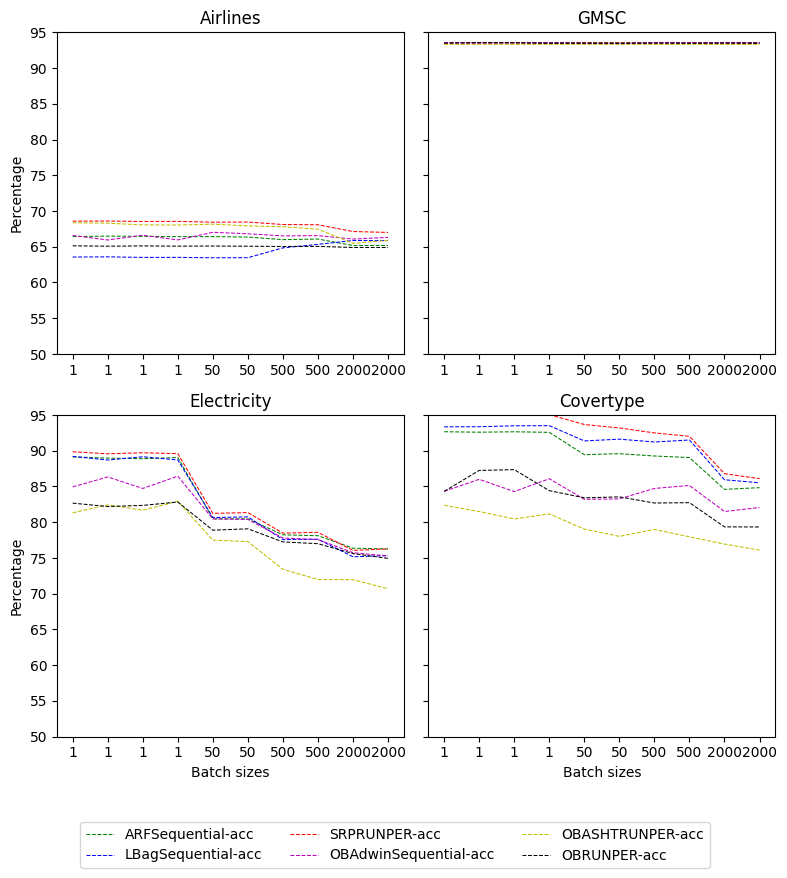

In [40]:
#false makes the chart without markers
display(df)
gen_chart(df,False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


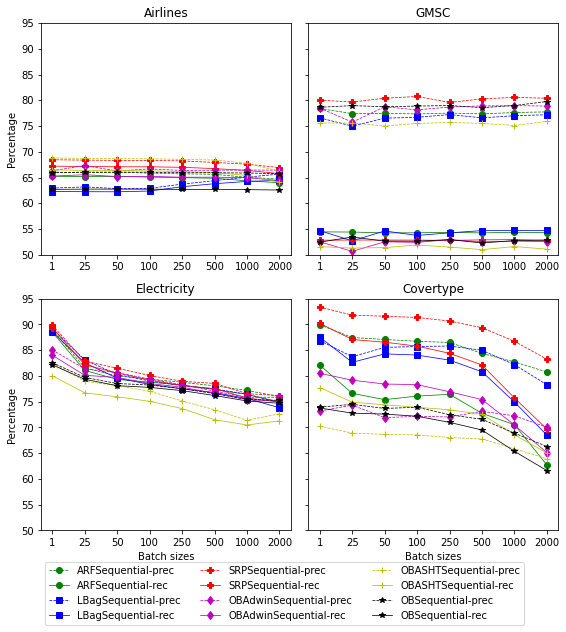

In [12]:
#by default, chart is generated with markers
gen_chart(df)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
86,airlines,ARFSequential,100,1,539383.0,66.414589,66.043304,65.254181,0.0
172,airlines,ARFMB,100,25,539383.0,66.334791,65.951729,65.188095,0.0
102,airlines,ARFMB,100,50,539383.0,66.380511,66.010556,65.213064,0.0
67,airlines,ARFMB,100,100,539383.0,66.243141,65.859263,65.087025,0.0
171,airlines,ARFMB,100,250,539383.0,66.118750,65.722388,64.977015,0.0
117,airlines,ARFMB,100,500,539383.0,66.020268,65.626472,64.864937,0.0
30,airlines,ARFMB,100,1000,539383.0,65.479408,65.041981,64.363996,0.0
166,airlines,ARFMB,100,2000,539383.0,65.136597,64.695100,63.996023,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
164,airlines,LBagSequential,100,1,539383.0,63.506451,62.952777,62.284959,7668.0
175,airlines,LBagMB,100,25,539383.0,63.665135,63.183091,62.250714,21495.0
72,airlines,LBagMB,100,50,539383.0,63.411658,62.844654,62.231749,6271.0
189,airlines,LBagMB,100,100,539383.0,63.481326,62.909626,62.382381,5374.0
111,airlines,LBagMB,100,250,539383.0,64.255388,63.721624,63.213412,2150.0
48,airlines,LBagMB,100,500,539383.0,64.884214,64.394678,63.801888,1022.0
155,airlines,LBagMB,100,1000,539383.0,65.465291,65.069871,64.240958,538.0
169,airlines,LBagMB,100,2000,539383.0,65.886714,65.669007,64.458234,263.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
33,airlines,SRPSequential,100,1,539383.0,68.532935,68.454073,67.208018,0.0
91,airlines,SRPMB,100,25,539383.0,68.468624,68.379553,67.147913,0.0
4,airlines,SRPMB,100,50,539383.0,68.415617,68.330271,67.086192,0.0
49,airlines,SRPMB,100,100,539383.0,68.410834,68.324404,67.083460,0.0
105,airlines,SRPMB,100,250,539383.0,68.316723,68.228427,66.985210,0.0
62,airlines,SRPMB,100,500,539383.0,68.050950,67.930550,66.732088,0.0
11,airlines,SRPMB,100,1000,539383.0,67.719077,67.590630,66.386221,0.0
42,airlines,SRPMB,100,2000,539383.0,67.098885,66.932101,65.758525,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
146,airlines,OBAdwinSequential,100,1,539383.0,66.575142,66.303461,65.263242,0.0
53,airlines,OBAdwinMB,100,25,539383.0,67.204343,67.335195,65.550289,0.0
16,airlines,OBAdwinMB,100,50,539383.0,66.517717,66.253396,65.188320,3519.0
65,airlines,OBAdwinMB,100,100,539383.0,66.749369,66.678034,65.222587,0.0
14,airlines,OBAdwinMB,100,250,539383.0,66.524958,66.375601,65.057090,0.0
35,airlines,OBAdwinMB,100,500,539383.0,66.546356,66.416628,65.065845,732.0
141,airlines,OBAdwinMB,100,1000,539383.0,66.512873,66.454215,64.968877,0.0
55,airlines,OBAdwinMB,100,2000,539383.0,66.208458,66.431020,64.413176,229.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
51,airlines,OBASHTSequential,100,1,539383.0,68.292846,68.811423,66.495396,0.0
60,airlines,OBASHTMB,100,25,539383.0,68.189588,68.715834,66.377265,0.0
34,airlines,OBASHTMB,100,50,539383.0,68.154183,68.662560,66.349183,0.0
142,airlines,OBASHTMB,100,100,539383.0,68.110806,68.646581,66.287041,0.0
174,airlines,OBASHTMB,100,250,539383.0,67.996209,68.523900,66.168914,0.0
148,airlines,OBASHTMB,100,500,539383.0,67.817504,68.399373,65.946891,0.0
24,airlines,OBASHTMB,100,1000,539383.0,67.270140,67.752893,65.410425,0.0
191,airlines,OBASHTMB,100,2000,539383.0,65.954450,66.232732,64.089063,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
150,airlines,OBSequential,100,1,539383.0,65.073612,65.953953,62.706905,0.0
104,airlines,OBMB,100,25,539383.0,65.126873,66.042785,62.751026,0.0
78,airlines,OBMB,100,50,539383.0,65.127852,66.038503,62.755347,0.0
22,airlines,OBMB,100,100,539383.0,65.119983,66.030295,62.748359,0.0
71,airlines,OBMB,100,250,539383.0,65.056118,65.940420,62.692298,0.0
82,airlines,OBMB,100,500,539383.0,65.052896,65.935282,62.696696,0.0
185,airlines,OBMB,100,1000,539383.0,64.996852,65.873123,62.651388,0.0
176,airlines,OBMB,100,2000,539383.0,64.901569,65.764964,62.570137,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
190,GMSC,ARFSequential,100,1,150000.0,93.571333,78.403665,54.451808,0.0
93,GMSC,ARFMB,100,25,150000.0,93.538923,77.402905,54.416780,0.0
85,GMSC,ARFMB,100,50,150000.0,93.532511,77.473664,54.247248,0.0
20,GMSC,ARFMB,100,100,150000.0,93.529686,77.347438,54.274881,0.0
178,GMSC,ARFMB,100,250,150000.0,93.537896,77.508038,54.352911,0.0
103,GMSC,ARFMB,100,500,150000.0,93.525084,77.361519,54.245875,0.0
13,GMSC,ARFMB,100,1000,150000.0,93.536913,77.615139,54.382079,0.0
43,GMSC,ARFMB,100,2000,150000.0,93.531081,77.747622,54.285137,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
95,GMSC,LBagSequential,100,1,150000.0,93.522000,76.587549,54.684644,20.0
39,GMSC,LBagMB,100,25,150000.0,93.402900,74.981337,52.713694,4292.0
165,GMSC,LBagMB,100,50,150000.0,93.517839,76.525859,54.628449,19.0
162,GMSC,LBagMB,100,100,150000.0,93.486324,76.691590,53.760541,1073.0
137,GMSC,LBagMB,100,250,150000.0,93.524541,77.217311,54.266923,430.0
44,GMSC,LBagMB,100,500,150000.0,93.519064,76.586716,54.697623,6.0
151,GMSC,LBagMB,100,1000,150000.0,93.532215,77.001280,54.719443,108.0
100,GMSC,LBagMB,100,2000,150000.0,93.534459,77.190645,54.731863,3.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
94,GMSC,SRPSequential,100,1,150000.0,93.509333,80.018151,52.825927,0.0
2,GMSC,SRPMB,100,25,150000.0,93.506918,79.659682,52.871315,0.0
124,GMSC,SRPMB,100,50,150000.0,93.518506,80.396943,52.859498,0.0
109,GMSC,SRPMB,100,100,150000.0,93.523682,80.743221,52.853944,0.0
17,GMSC,SRPMB,100,250,150000.0,93.499165,79.583840,52.792609,0.0
25,GMSC,SRPMB,100,500,150000.0,93.515050,80.264206,52.898793,0.0
64,GMSC,SRPMB,100,1000,150000.0,93.520805,80.560839,52.948737,0.0
58,GMSC,SRPMB,100,2000,150000.0,93.504730,80.394093,52.833234,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
144,GMSC,OBAdwinSequential,100,1,150000.0,93.464667,78.493259,52.528835,0.0
15,GMSC,OBAdwinMB,100,25,150000.0,93.342890,75.745457,50.662310,0.0
87,GMSC,OBAdwinMB,100,50,150000.0,93.469156,78.739334,52.527364,11.0
21,GMSC,OBAdwinMB,100,100,150000.0,93.452302,78.136939,52.412620,0.0
112,GMSC,OBAdwinMB,100,250,150000.0,93.491820,78.688918,52.941700,0.0
161,GMSC,OBAdwinMB,100,500,150000.0,93.466890,78.899623,52.510865,8.0
120,GMSC,OBAdwinMB,100,1000,150000.0,93.473826,78.951993,52.658176,0.0
5,GMSC,OBAdwinMB,100,2000,150000.0,93.462162,78.878810,52.571573,5.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
126,GMSC,OBASHTSequential,100,1,150000.0,93.314000,75.6,51.6,NaN
29,GMSC,OBASHTMB,100,25,150000.0,93.315553,75.6,51.3,NaN
173,GMSC,OBASHTMB,100,50,150000.0,93.314438,75.0,51.4,NaN
77,GMSC,OBASHTMB,100,100,150000.0,93.316211,75.5,51.9,NaN
88,GMSC,OBASHTMB,100,250,150000.0,93.315526,75.7,51.5,NaN
149,GMSC,OBASHTMB,100,500,150000.0,93.312375,75.5,51.0,NaN
57,GMSC,OBASHTMB,100,1000,150000.0,93.309396,75.1,51.6,NaN
99,GMSC,OBASHTMB,100,2000,150000.0,93.304054,75.9,51.1,NaN


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
101,GMSC,OBSequential,100,1,150000.0,93.462667,78.635690,52.453686,0.0
183,GMSC,OBMB,100,25,150000.0,93.529588,78.964603,53.457738,0.0
63,GMSC,OBMB,100,50,150000.0,93.476492,78.737009,52.651719,0.0
97,GMSC,OBMB,100,100,150000.0,93.477652,78.874661,52.634691,0.0
76,GMSC,OBMB,100,250,150000.0,93.497830,78.974591,52.949558,0.0
73,GMSC,OBMB,100,500,150000.0,93.448829,78.564176,52.296914,0.0
167,GMSC,OBMB,100,1000,150000.0,93.480537,78.982894,52.759546,0.0
74,GMSC,OBMB,100,2000,150000.0,93.494595,79.752291,52.846536,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
127,elecNormNew,ARFSequential,100,1,45312.0,89.049258,89.017883,88.498921,0.0
107,elecNormNew,ARFMB,100,25,45312.0,81.824806,81.556148,81.055320,0.0
135,elecNormNew,ARFMB,100,50,45312.0,80.232866,79.968087,79.317356,0.0
45,elecNormNew,ARFMB,100,100,45312.0,79.682385,79.379887,78.782046,0.0
31,elecNormNew,ARFMB,100,250,45312.0,79.102126,78.752955,78.210955,0.0
163,elecNormNew,ARFMB,100,500,45312.0,78.383022,78.065967,77.355588,0.0
59,elecNormNew,ARFMB,100,1000,45312.0,77.520762,77.175766,76.393599,0.0
69,elecNormNew,ARFMB,100,2000,45312.0,76.189047,75.976955,74.858875,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
168,elecNormNew,LBagSequential,100,1,45312.0,89.159605,89.182638,88.562081,462.0
157,elecNormNew,LBagMB,100,25,45312.0,83.291011,83.107838,82.519561,1803.0
134,elecNormNew,LBagMB,100,50,45312.0,80.493571,80.258739,79.558881,413.0
154,elecNormNew,LBagMB,100,100,45312.0,79.299743,79.007250,78.347266,452.0
52,elecNormNew,LBagMB,100,250,45312.0,78.449692,78.104076,77.485558,181.0
131,elecNormNew,LBagMB,100,500,45312.0,77.789431,77.431248,76.767421,83.0
132,elecNormNew,LBagMB,100,1000,45312.0,76.805380,76.454690,75.605636,46.0
89,elecNormNew,LBagMB,100,2000,45312.0,75.152383,74.853471,73.820960,23.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
136,elecNormNew,SRPSequential,100,1,45312.0,89.859198,89.831174,89.354659,0.0
81,elecNormNew,SRPMB,100,25,45312.0,82.990704,82.853920,82.138564,0.0
188,elecNormNew,SRPMB,100,50,45312.0,81.591622,81.493553,80.583211,0.0
116,elecNormNew,SRPMB,100,100,45312.0,80.222065,80.072788,79.162539,0.0
106,elecNormNew,SRPMB,100,250,45312.0,79.175358,78.940153,78.115908,0.0
125,elecNormNew,SRPMB,100,500,45312.0,78.715523,78.538534,77.529993,0.0
156,elecNormNew,SRPMB,100,1000,45312.0,76.906933,76.555614,75.719984,0.0
3,elecNormNew,SRPMB,100,2000,45312.0,76.311415,76.173636,74.907337,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
92,elecNormNew,OBAdwinSequential,100,1,45312.0,84.939972,85.030812,84.002821,0.0
7,elecNormNew,OBAdwinMB,100,25,45312.0,81.299269,81.359479,80.110205,0.0
170,elecNormNew,OBAdwinMB,100,50,45312.0,80.738810,80.614454,79.687973,463.0
119,elecNormNew,OBAdwinMB,100,100,45312.0,79.578431,79.385187,78.514542,0.0
70,elecNormNew,OBAdwinMB,100,250,45312.0,78.658293,78.274794,77.786270,0.0
41,elecNormNew,OBAdwinMB,100,500,45312.0,77.492636,77.040202,76.631640,86.0
0,elecNormNew,OBAdwinMB,100,1000,45312.0,76.340495,75.831889,75.407197,0.0
1,elecNormNew,OBAdwinMB,100,2000,45312.0,76.205209,75.851028,75.079469,23.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
128,elecNormNew,OBASHTSequential,100,1,45312.0,81.686970,82.462926,80.034659,0.0
115,elecNormNew,OBASHTMB,100,25,45312.0,78.466227,78.964210,76.695624,0.0
147,elecNormNew,OBASHTMB,100,50,45312.0,77.705360,78.086243,75.939594,0.0
160,elecNormNew,OBASHTMB,100,100,45312.0,76.795983,77.020743,75.062543,0.0
113,elecNormNew,OBASHTMB,100,250,45312.0,75.247437,75.115309,73.653057,0.0
186,elecNormNew,OBASHTMB,100,500,45312.0,73.440150,73.430273,71.490298,0.0
158,elecNormNew,OBASHTMB,100,1000,45312.0,71.944394,71.369791,70.466259,0.0
108,elecNormNew,OBASHTMB,100,2000,45312.0,72.915127,72.645718,71.264238,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
18,elecNormNew,OBSequential,100,1,45312.0,82.825742,82.555283,82.143320,0.0
36,elecNormNew,OBMB,100,25,45312.0,80.073752,79.697578,79.337452,0.0
179,elecNormNew,OBMB,100,50,45312.0,78.911670,78.516899,78.095057,0.0
23,elecNormNew,OBMB,100,100,45312.0,78.609661,78.218330,77.763826,0.0
75,elecNormNew,OBMB,100,250,45312.0,77.948160,77.505492,77.129578,0.0
139,elecNormNew,OBMB,100,500,45312.0,77.030706,76.550699,76.185508,0.0
38,elecNormNew,OBMB,100,1000,45312.0,75.968135,75.416350,75.125134,0.0
27,elecNormNew,OBMB,100,2000,45312.0,75.694958,75.253898,74.675709,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
56,covtypeNorm,ARFSequential,100,1,581012.0,92.651271,89.915437,82.077955,0.0
122,covtypeNorm,ARFMB,100,25,581012.0,90.040397,87.440099,76.606011,0.0
140,covtypeNorm,ARFMB,100,50,581012.0,89.635295,87.064107,75.385218,0.0
184,covtypeNorm,ARFMB,100,100,581012.0,90.015527,86.711141,76.071801,0.0
47,covtypeNorm,ARFMB,100,250,581012.0,90.412596,86.487356,76.419809,0.0
26,covtypeNorm,ARFMB,100,500,581012.0,89.097728,84.361893,72.724937,0.0
84,covtypeNorm,ARFMB,100,1000,581012.0,88.179555,82.693695,70.514299,0.0
187,covtypeNorm,ARFMB,100,2000,581012.0,84.806533,80.758048,62.701375,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
153,covtypeNorm,LBagSequential,100,1,581012.0,93.357624,86.852533,87.512520,6457.0
123,covtypeNorm,LBagMB,100,25,581012.0,90.588946,83.716337,82.632537,23206.0
159,covtypeNorm,LBagMB,100,50,581012.0,91.880536,85.532761,84.272239,5804.0
32,covtypeNorm,LBagMB,100,100,581012.0,91.957646,85.696677,84.037295,5803.0
182,covtypeNorm,LBagMB,100,250,581012.0,92.166154,85.795857,83.051487,2322.0
138,covtypeNorm,LBagMB,100,500,581012.0,91.441004,84.965074,80.793761,1121.0
80,covtypeNorm,LBagMB,100,1000,581012.0,89.322290,82.175620,74.915421,582.0
10,covtypeNorm,LBagMB,100,2000,581012.0,85.816183,78.268754,68.488402,290.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
152,covtypeNorm,SRPSequential,100,1,581012.0,95.347600,93.349242,90.185556,0.0
177,covtypeNorm,SRPMB,100,25,581012.0,93.812942,91.789395,87.062315,0.0
19,covtypeNorm,SRPMB,100,50,581012.0,93.689432,91.575290,86.533393,0.0
66,covtypeNorm,SRPMB,100,100,581012.0,93.586980,91.332429,85.778296,0.0
50,covtypeNorm,SRPMB,100,250,581012.0,93.381971,90.650374,84.378597,0.0
110,covtypeNorm,SRPMB,100,500,581012.0,92.516606,89.350072,82.117661,0.0
180,covtypeNorm,SRPMB,100,1000,581012.0,90.235030,86.695455,75.710474,0.0
143,covtypeNorm,SRPMB,100,2000,581012.0,86.799237,83.237686,69.660146,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
9,covtypeNorm,OBAdwinSequential,100,1,581012.0,84.290342,73.169006,80.494976,0.0
28,covtypeNorm,OBAdwinMB,100,25,581012.0,83.146094,74.324896,79.161199,0.0
121,covtypeNorm,OBAdwinMB,100,50,581012.0,83.151394,71.892483,78.417638,6105.0
68,covtypeNorm,OBAdwinMB,100,100,581012.0,83.383886,72.143207,78.300181,0.0
79,covtypeNorm,OBAdwinMB,100,250,581012.0,84.021510,72.022062,76.908718,0.0
83,covtypeNorm,OBAdwinMB,100,500,581012.0,84.696268,73.112193,75.389995,1151.0
90,covtypeNorm,OBAdwinMB,100,1000,581012.0,84.143776,72.240649,70.468109,0.0
96,covtypeNorm,OBAdwinMB,100,2000,581012.0,82.070492,70.035378,65.083867,291.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
46,covtypeNorm,OBASHTSequential,100,1,581012.0,81.164417,70.212116,77.727120,0.0
98,covtypeNorm,OBASHTMB,100,25,581012.0,79.402465,68.893897,74.898882,0.0
130,covtypeNorm,OBASHTMB,100,50,581012.0,79.096223,68.630722,74.380764,0.0
145,covtypeNorm,OBASHTMB,100,100,581012.0,78.951201,68.542441,73.901732,0.0
40,covtypeNorm,OBASHTMB,100,250,581012.0,79.029792,68.022959,73.411753,0.0
114,covtypeNorm,OBASHTMB,100,500,581012.0,78.978557,67.737079,72.540777,0.0
6,covtypeNorm,OBASHTMB,100,1000,581012.0,78.184244,65.874526,68.558489,0.0
61,covtypeNorm,OBASHTMB,100,2000,581012.0,76.926040,63.910828,65.015357,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
37,covtypeNorm,OBSequential,100,1,581012.0,84.417017,73.920788,73.767746,0.0
54,covtypeNorm,OBMB,100,25,581012.0,83.973480,74.480218,72.755817,0.0
8,covtypeNorm,OBMB,100,50,581012.0,83.678106,73.669973,72.580262,0.0
129,covtypeNorm,OBMB,100,100,581012.0,83.802366,73.917526,72.158936,0.0
133,covtypeNorm,OBMB,100,250,581012.0,83.550749,72.448347,70.972202,0.0
118,covtypeNorm,OBMB,100,500,581012.0,82.987949,71.566745,69.488389,0.0
181,covtypeNorm,OBMB,100,1000,581012.0,81.501762,68.879476,65.343444,0.0
12,covtypeNorm,OBMB,100,2000,581012.0,79.500770,66.285623,61.620102,0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


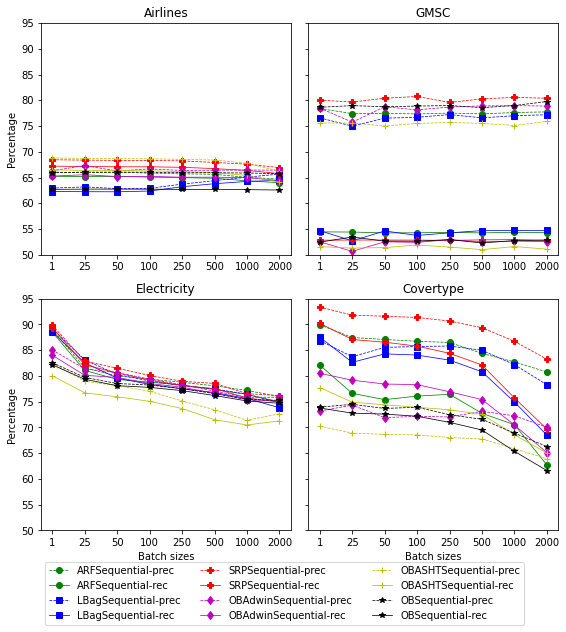

In [13]:
#by default, chart is generated with markers
#the modifier tables outputs the tables used for each serie of the chart
gen_chart(df, tables=True)